# CNN - Classification + bounding boxes

In [2]:
# !pip install git+https://github.com/fastai/fastai.git

In [109]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

from pathlib import Path

import fastai
from fastai.conv_learner import ConvLearner, ConvnetBuilder
from fastai.transforms import RandomRotate, RandomLighting, tfms_from_model, CropType, TfmType
from fastai.dataset import ImageClassifierData, get_cv_idxs
from torchvision.models.resnet import resnet101
from fastai.layers import Flatten
from matplotlib import patches, patheffects
from torch import nn
from torch import optim
from torch.nn import functional as F
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from torch.utils.data import Dataset
from fastai.core import to_np

In [61]:
def bb_hw(bb):
    ymin, xmin, ymax, xmax = bb
    return np.array([xmin, ymin, xmax - xmin + 1, ymax - ymin + 1])

In [62]:
def draw_outline(o, lw):
    o.set_path_effects([patheffects.Stroke(
        linewidth=lw, foreground='black'), patheffects.Normal()])

In [63]:
def draw_rect(ax, b, color='white'):
    patch = ax.add_patch(patches.Rectangle(b[:2], *b[-2:], fill=False, edgecolor=color, lw=2))
    draw_outline(patch, 4)

In [64]:
def draw_text(ax, xy, txt, sz=14):
    text = ax.text(*xy, txt,
        verticalalignment='top', color='white', fontsize=sz, weight='bold')
    draw_outline(text, 1)

In [65]:
def show_img(im, figsize=None, ax=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    return ax

In [66]:
arch = resnet101
size = 224
batch_size = 32

In [67]:
PATH = Path('../data')

In [68]:
df_class = pd.read_csv(PATH/'train_classes.csv')
df_bb = pd.read_csv(PATH/'train_bbs.csv')

In [69]:
df_class.head()

,image,class
0,EBH3wdRtZyg-frame-5854.jpg,s
1,EBH3wdRtZyg-frame-5897.jpg,t
2,EBH3wdRtZyg-frame-4237.jpg,b
3,pAz_mIjHglw-frame-528.jpg,l
4,33qU9tQlEa4-frame-610.jpg,d


In [70]:
df_bb.head()

,image,bb
0,EBH3wdRtZyg-frame-5854.jpg,151 34 360 295
1,EBH3wdRtZyg-frame-5897.jpg,81 75 360 241
2,EBH3wdRtZyg-frame-4237.jpg,115 108 311 393
3,pAz_mIjHglw-frame-528.jpg,150 173 507 538
4,33qU9tQlEa4-frame-610.jpg,173 324 644 868


In [71]:
val_idxs = get_cv_idxs(len(df_class))

In [72]:
augs = [RandomRotate(30, tfm_y=TfmType.COORD), RandomLighting(0.1,0.1, tfm_y=TfmType.COORD)]

In [73]:
tfms = tfms_from_model(arch, size, crop_type=CropType.NO, aug_tfms=augs, tfm_y=TfmType.COORD, norm_y=False)
bb_model_data = ImageClassifierData.from_csv(PATH, 'yolo', PATH/'train_bbs.csv', tfms=tfms, continuous=True, bs=batch_size, val_idxs=val_idxs)

In [74]:
class_model_data = ImageClassifierData.from_csv(PATH, 'yolo', PATH/'train_classes.csv', tfms=tfms_from_model(arch, size))

In [75]:
class ConcatLabelledDataset(Dataset):
    def __init__(self, ds, y2):
        self.ds = ds
        self.y2 = y2
        
    def __len__(self):
        return len(self.ds)
    
    def __getitem__(self, i):
        x ,y = self.ds[i]
        return (x, (y,self.y2[i]))

In [76]:
trn_ds2 = ConcatLblDataset(bb_model_data.trn_ds, class_model_data.trn_y)
val_ds2 = ConcatLblDataset(bb_model_data.val_ds, class_model_data.val_y)

In [77]:
val_ds2[0][1]

(array([ 72.,  52., 192., 182.], dtype=float32), 1)

In [78]:
bb_model_data.trn_dl.dataset = trn_ds2
bb_model_data.val_dl.dataset = val_ds2

In [98]:
iter_val = iter(bb_model_data.val_dl)

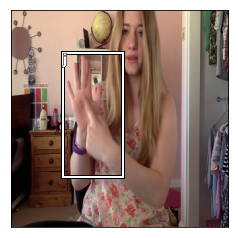

In [99]:
x, y = next(iter_val)
idx = 3
ima = bb_model_data.val_ds.ds.denorm(to_np(x))[idx]
b = bb_hw(to_np(y[0][idx]))
ax = show_img(ima)
draw_rect(ax, b)
draw_text(ax, b[:2], class_model_data.classes[y[1][idx]])

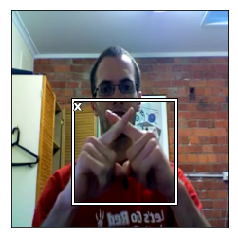

In [100]:
x, y = next(iter_val)
idx = 4
ima = bb_model_data.val_ds.ds.denorm(to_np(x))[idx]
b = bb_hw(to_np(y[0][idx]))
ax = show_img(ima)
draw_rect(ax, b)
draw_text(ax, b[:2], class_model_data.classes[y[1][idx]])

In [101]:
2048*7*7

100352

In [110]:
model_head = nn.Sequential(
    Flatten(),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(100352, 256),
    nn.ReLU(),
    nn.BatchNorm1d(256),
    nn.Dropout(0.5),
    nn.Linear(256, 4 + len(class_model_data.classes))
)
models = ConvnetBuilder(arch, 0, 0, 0, custom_head=model_head)

learn = ConvLearner(bb_model_data, models)
learn.opt_fn = optim.Adam

In [121]:
def detn_loss(input, target):
    # Picked a multiplier that makes cross ent and l1 loss equal
    cross_mult = 35
    
    bb_t, c_t = target
    bb_i, c_i = input[:, :4], input[:, 4:]

    bb_i = F.sigmoid(bb_i) * size
    
    return F.l1_loss(bb_i, bb_t) + F.cross_entropy(c_i, c_t) * cross_mult

def detn_l1(input, target):
    bb_t,_ = target
    bb_i = input[:, :4]
    bb_i = F.sigmoid(bb_i) * 224
    return F.l1_loss(V(bb_i),V(bb_t)).data

def detn_acc(input, target):
    _,c_t = target
    c_i = input[:, 4:]
    return accuracy(c_i, c_t)

learn.crit = detn_loss
learn.metrics = [detn_acc, detn_l1]

In [122]:
learn.lr_find(1e-5, 100)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 83%|████████▎ | 20/24 [02:37<00:31,  7.89s/it, loss=337]

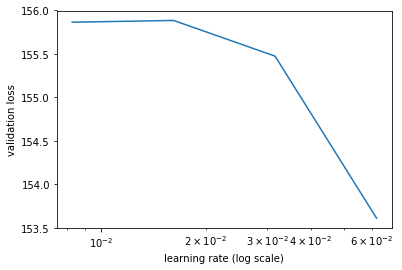

In [123]:
learn.sched.plot()

In [124]:
lr = 0.002

In [ ]:
learn.fit(lr, 2, cycle_len=1, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

 17%|█▋        | 4/24 [00:36<03:01,  9.07s/it, loss=158]

In [44]:
learn.fit(lr, 2, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss                             
    0      12.792475  9.101788  
    1      13.852755  9.614405                             
    2      9.941295   7.294629                             



[array([7.29463])]

In [46]:
learn.freeze_to(-2)

epoch      trn_loss   val_loss                             
    0      84.525997  3.0842303070348013e+29



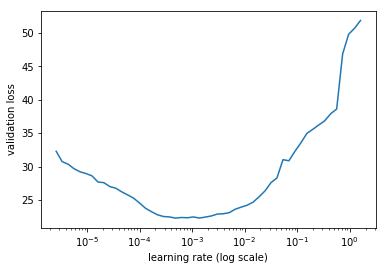

In [47]:
lrf=learn.lr_find(lrs/1000)
learn.sched.plot(1)

In [48]:
lr = 0.0005
lrs = np.array([lr/100, lr/10, lr])

In [49]:
learn.fit(lrs, 2, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss                             
    0      14.355611  9.64333   
    1      10.864135  8.586794                             
    2      8.189152   6.590679                             



[array([6.59068])]

In [50]:
learn.freeze_to(-3)

In [51]:
learn.fit(lrs, 1, cycle_len=2)

epoch      trn_loss   val_loss                             
    0      9.265743   8.740417  
    1      7.321788   6.269617                             



[array([6.26962])]

## Evaluate

In [52]:
from fastai.core import VV
from scipy.special import expit

In [53]:
y = learn.predict()
x,_ = next(iter(bb_model_data.val_dl))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


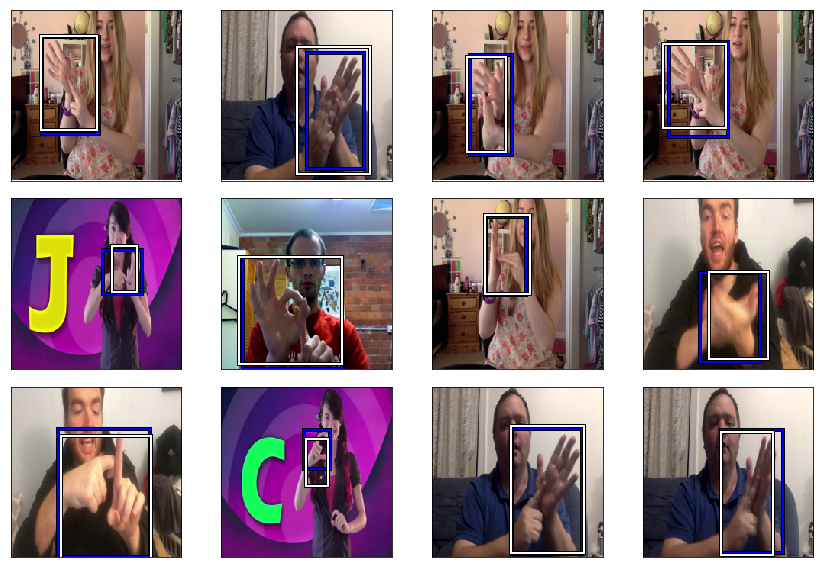

In [69]:
fig, axes = plt.subplots(3, 4, figsize=(12, 8))
for i,ax in enumerate(axes.flat):
    ima = bb_model_data.val_ds.ds.denorm(to_np(x))[i]
    bb = expit(y[i][:4])*224
    b = bb_hw(bb)
    c = np.argmax(y[i][4:])
    ax = show_img(ima, ax=ax)
    draw_rect(ax, b)
    draw_text(ax, b[:2], md2.classes[c])
    
plt.tight_layout()